# Initial Experiments with SpinePredictions_500taks_PXV_1S_10_15_19

## Notes from E

Lumbar Moment Predictions – 1 subject, 94 trials, ~411 subtasks
Goal: Predict triaxial lumbar moment using wearable sensors signals
Data overview
Notes:
- Two dataset options (would be interesting to see results from both)
    - `lumbar_results1.csv`: lab-based targets, lab-based predictors (all trials)
    - `lumbar_results2.csv`: lab-based target, wearable predictors (subset of trials)
    - `lumbar_results3.csv`: lab-based targets, lab-based predictors (same subset of trials as above)
- I did not delete any samples were a target or a predictor did not exist. You can choose to handle those however you think is best. 
    - Note: Samples when `CoP` variables `==` `NaN` may still be important, can we consider other ways to handle these sampes?
- You could consider deleting any samples when `Pelvis_Moment_X > 0`
- One tasks was repeated 6x throughout, and may be useful for testing / validation. `S01_5kg, S02_5kg, S03_5kg, S04_5kg, S0_5kg, S06_5kg`
 

## Imports

In [1]:
# Standard library

# Third party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import linear_model, svm, ensemble
from sklearn import metrics, preprocessing, pipeline, model_selection


# Local
import utils

In [2]:
# matplotlib hackery - needs to be in a separate cell for now: https://github.com/jupyter/notebook/issues/3385
plt.rcParams["figure.figsize"] = (13,6)

## Load and describe dataset

In [3]:
dataset_name = "lumbar_results_PXV_10_15_19.csv" # lab-based targets, lab-based predictors (all trials)
#dataset_name = "lumbar_results2_PXV_10_15_19.csv" # lab-based target, wearable predictors (subset of trials)
#dataset_name = "lumbar_results3_PXV_10_15_19.csv" # lab-based targets, lab-based predictors (same subset of trials as above)


df_orig = utils.load_dataset("s3://cpac/ORIG/SpinePredictions_500taks_PXV_1S_10_15_19/" + dataset_name)
df_orig.describe()

,Trial_Index,Mass,Pelvis_Moment_X,Pelvis_Moment_Y,Pelvis_Moment_Z,Lumbar_Ang_X,Lumbar_Ang_Y,Lumbar_Ang_Z,RIGHT_ANKLE_ANGLE_X,RIGHT_ANKLE_ANGLE_Y,...,RIGHT_ELBOW_ANGLE_Z,LEFT_ELBOW_ANGLE_X,LEFT_ELBOW_ANGLE_Y,LEFT_ELBOW_ANGLE_Z,GRF_RightFoot_Z,GRF_LeftFoot_Z,CoP_RightFoot_X,CoP_RightFoot_Y,CoP_LeftFoot_X,CoP_LeftFoot_Y
count,440099.000000,440099.000000,420091.000000,420091.000000,420091.000000,425858.000000,425858.000000,425858.000000,432029.000000,432029.000000,...,433800.000000,434389.000000,434389.000000,434389.000000,434255.000000,434383.000000,388580.000000,388580.000000,383484.000000,383484.000000
mean,5541.332650,10.114038,-79.201840,6.015842,-4.532530,-14.296310,-2.532971,7.191949,8.836677,4.663428,...,10.899939,39.874746,48.903471,3.519017,432.265496,432.400849,0.010951,0.081804,-0.017532,0.074156
std,4779.881023,5.656170,72.202265,32.773121,10.514628,16.163765,5.033335,6.970807,9.165075,5.780055,...,38.143621,51.192461,19.747197,44.613659,285.564634,283.883430,0.015879,0.054170,0.011827,0.055104
min,1.000000,0.000000,-383.737732,-1354.738403,-589.455627,-51.470860,-21.789438,-31.083050,-22.147808,-29.222076,...,-179.988220,-179.989319,1.157911,-179.808731,0.000000,0.000000,-0.094840,-0.116729,-0.061360,-0.076694
25%,1503.000000,5.000000,-137.655846,-9.354234,-8.392385,-31.184018,-5.049417,4.419876,3.781092,1.108795,...,-15.942439,10.177932,32.768112,-12.021628,172.948654,167.617905,0.003537,0.038270,-0.023384,0.031540
50%,4046.000000,10.000000,-60.433578,4.725657,-2.623494,-7.282486,-2.977192,7.461900,7.602348,4.600018,...,1.536669,17.831430,47.184483,20.594257,423.936157,450.983490,0.015361,0.074660,-0.018967,0.059726
75%,8793.000000,15.000000,-14.523448,22.457512,0.208967,-1.544644,-0.175618,10.335788,12.012715,8.043282,...,24.292919,57.986584,65.735817,31.475016,687.548309,676.597137,0.021791,0.130671,-0.014147,0.119867
max,19196.000000,23.000000,828.435364,1486.570312,1446.556641,17.365082,16.969116,40.871311,40.322681,43.005413,...,179.837982,179.999039,89.920540,179.844711,1409.124756,1483.652100,0.079593,0.234113,0.090913,0.220129


## Cleaning the dataset

In [4]:
meta = ["Trial_Name"]
print(f"Meta ({len(meta)}): {meta}")

targets = [
           "Pelvis_Moment_X", 
#           "Pelvis_Moment_Y", 
#           "Pelvis_Moment_Z", 
#           "single_equiv_force", 
#           "poly_force",
]
print(f"Targets ({len(targets)}): {targets}")

features = df_orig.loc[:, "Lumbar_Ang_X":].columns.to_list()
print(f"Features ({len(features)}): {features}")

ignored = set(df_orig.columns) - set(meta + features + targets)
print(f"Ignored ({len(ignored)}): {ignored}")

df = df_orig[meta + targets + features].dropna()
df = df[df["Pelvis_Moment_X"] <= 0]

print(f"Number of samples: {df.shape[0]} (orig: {df_orig.shape[0]})")
print("Number of trials:", len(df_orig["Trial_Name"].unique()))

df.describe()

Meta (1): ['Trial_Name']
Targets (1): ['Pelvis_Moment_X']
Features (39): ['Lumbar_Ang_X', 'Lumbar_Ang_Y', 'Lumbar_Ang_Z', 'RIGHT_ANKLE_ANGLE_X', 'RIGHT_ANKLE_ANGLE_Y', 'RIGHT_ANKLE_ANGLE_Z', 'LEFT_ANKLE_ANGLE_X', 'LEFT_ANKLE_ANGLE_Y', 'LEFT_ANKLE_ANGLE_Z', 'RIGHT_KNEE_ANGLE_X', 'RIGHT_KNEE_ANGLE_Y', 'RIGHT_KNEE_ANGLE_Z', 'LEFT_KNEE_ANGLE_X', 'LEFT_KNEE_ANGLE_Y', 'LEFT_KNEE_ANGLE_Z', 'RIGHT_HIP_ANGLE_X', 'RIGHT_HIP_ANGLE_Y', 'RIGHT_HIP_ANGLE_Z', 'LEFT_HIP_ANGLE_X', 'LEFT_HIP_ANGLE_Y', 'LEFT_HIP_ANGLE_Z', 'RIGHT_SHOULDER_ANGLE_X', 'RIGHT_SHOULDER_ANGLE_Y', 'RIGHT_SHOULDER_ANGLE_Z', 'LEFT_SHOULDER_ANGLE_X', 'LEFT_SHOULDER_ANGLE_Y', 'LEFT_SHOULDER_ANGLE_Z', 'RIGHT_ELBOW_ANGLE_X', 'RIGHT_ELBOW_ANGLE_Y', 'RIGHT_ELBOW_ANGLE_Z', 'LEFT_ELBOW_ANGLE_X', 'LEFT_ELBOW_ANGLE_Y', 'LEFT_ELBOW_ANGLE_Z', 'GRF_RightFoot_Z', 'GRF_LeftFoot_Z', 'CoP_RightFoot_X', 'CoP_RightFoot_Y', 'CoP_LeftFoot_X', 'CoP_LeftFoot_Y']
Ignored (5): {'Trial_Type', 'Pelvis_Moment_Y', 'Mass', 'Trial_Index', 'Pelvis_Moment_Z'}
Num

,Pelvis_Moment_X,Lumbar_Ang_X,Lumbar_Ang_Y,Lumbar_Ang_Z,RIGHT_ANKLE_ANGLE_X,RIGHT_ANKLE_ANGLE_Y,RIGHT_ANKLE_ANGLE_Z,LEFT_ANKLE_ANGLE_X,LEFT_ANKLE_ANGLE_Y,LEFT_ANKLE_ANGLE_Z,...,RIGHT_ELBOW_ANGLE_Z,LEFT_ELBOW_ANGLE_X,LEFT_ELBOW_ANGLE_Y,LEFT_ELBOW_ANGLE_Z,GRF_RightFoot_Z,GRF_LeftFoot_Z,CoP_RightFoot_X,CoP_RightFoot_Y,CoP_LeftFoot_X,CoP_LeftFoot_Y
count,308238.000000,308238.000000,308238.000000,308238.000000,308238.000000,308238.000000,308238.000000,308238.000000,308238.000000,308238.000000,...,308238.000000,308238.000000,308238.000000,308238.000000,308238.000000,308238.000000,308238.000000,308238.000000,308238.000000,308238.000000
mean,-80.601433,-14.028214,-2.809446,7.448687,9.402049,4.465910,-17.349213,4.919571,-2.437700,6.498215,...,12.309083,41.928527,49.517484,1.722777,428.823432,446.318928,0.009107,0.085028,-0.016731,0.076952
std,72.825198,16.423478,4.723390,6.954099,9.670553,5.495160,6.722517,8.291183,5.207115,7.877696,...,38.975936,52.839548,19.570715,45.670022,236.643447,235.691678,0.016511,0.055562,0.012102,0.056057
min,-383.737732,-51.470860,-21.789438,-31.065828,-22.147808,-26.856560,-47.330582,-22.571825,-34.185665,-31.310127,...,-179.988220,-179.989319,1.157911,-179.808731,21.393166,11.250907,-0.094840,-0.101416,-0.061239,-0.046488
25%,-139.112663,-31.397774,-5.011043,4.907604,3.803573,1.331457,-21.057865,0.667688,-5.824531,3.406863,...,-15.533253,10.971461,33.442450,-17.054939,232.592823,249.171219,0.000648,0.039976,-0.022920,0.033390
50%,-58.040243,-6.682999,-3.023095,7.545622,7.558956,4.518350,-17.444326,3.176956,-2.468644,7.933172,...,1.901640,18.399989,47.980061,20.252111,421.667435,457.043564,0.013872,0.078541,-0.018612,0.062749
75%,-15.621037,-1.276330,-0.677005,10.323047,12.630628,7.470730,-13.968711,6.841680,0.678110,11.209891,...,28.005276,65.360207,66.222708,30.889073,610.287231,621.091537,0.020783,0.136836,-0.012910,0.125401
max,-0.000696,17.365082,16.918304,40.866344,40.322681,43.005413,98.092171,46.077217,23.822844,43.807041,...,179.837982,179.999039,89.880547,179.844711,1308.620728,1446.685913,0.079593,0.234113,0.042349,0.220129


## Understanding trials, find a good train/validation/test split

We are using the `S0*_5kg` trials as testing data.

In [5]:
trial_names = df["Trial_Name"].unique().tolist()
print(f"Trial names ({len(trial_names)}): {trial_names}") 

is_test = df['Trial_Name'].str.match("S0[0-9]_5kg")
df_test = df[is_test]
df_train = df[~is_test]
print(f"Train: {len(df_train)}, Test: {len(df_test)} ({len(df_test) / len(df):.1%})")


Trial names (85): ['IDP_extend60cm_20kg', 'IDP_latbendL_10deg_0kg', 'IDP_latbendL_20deg_0kg', 'IDP_latbendL_30deg_0kg', 'IDP_latbendR_10deg_0kg', 'IDP_latbendR_20deg_0kg', 'IDP_latbendR_30deg_0kg', 'IDP_lean_10deg_0kg', 'IDP_lean_20deg_0kg', 'IDP_lean_30deg_0kg', 'IDP_squat_20kg', 'IDP_stoop_20kg', 'IDP_twistL_0kg', 'IDP_twistR_0kg', 'IDP_upright_20kg', 'IDP_uprightchest_20kg', 'IDP_walkL_20kg', 'IDP_walkLandR_20kg', 'IDP_walkR_20kg', 'IDPc_extend60cm_5kg', 'IDPc_hold_LandR_20kg', 'IDPc_holdL_latbendL_20kg', 'IDPc_holdR_latbendR_20kg', 'IDPc_twistL_20kg', 'IDPc_upright_5kg', 'IDPc_uprightchest_5kg', 'S01_5kg', 'S02_5kg', 'S03_5kg', 'S04_5kg', 'S05_5kg', 'S06_5kg', 'S10_17_to_12_17_to_13_10kg', 'S10_17_to_12_17_to_13_15kg', 'S10_17_to_12_17_to_13_5kg', 'S10_17_to_15_17_to_16_10kg', 'S10_17_to_15_17_to_16_15kg', 'S10_17_to_15_17_to_16_5kg', 'S10_Freestyle_10kg', 'S10_Freestyle_15kg', 'S10_Freestyle_23kg', 'S10_Freestyle_5kg', 'S10_horizontal_box_circles_10kg', 'S10_horizontal_box_circles

## Simple linear regression

In [6]:
linreg = linear_model.LinearRegression()
linreg.fit(df_train[features], df_train[targets])
mse_linreg = metrics.mean_squared_error(linreg.predict(df_test[features]), df_test[targets])
print(f"MSE(linear regression): {mse_linreg:.2f}")

MSE(linear regression): 259.52


## Ridge regression

In [7]:
ridgereg = pipeline.Pipeline([
    ('scaler', preprocessing.StandardScaler()),
    ('ridge', linear_model.Ridge())
])
ridgereg.fit(df_train[features], df_train[targets])
mse_ridgereg = metrics.mean_squared_error(ridgereg.predict(df_test[features]), df_test[targets])
print(f"MSE(ridge regression): {mse_ridgereg:.2f}")

MSE(ridge regression): 259.52


## Lasso regression


MSE(Lasso regression): 275.75


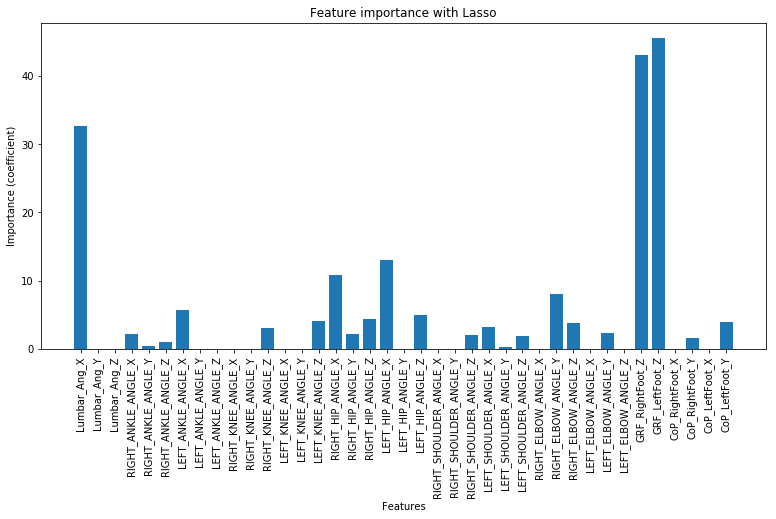

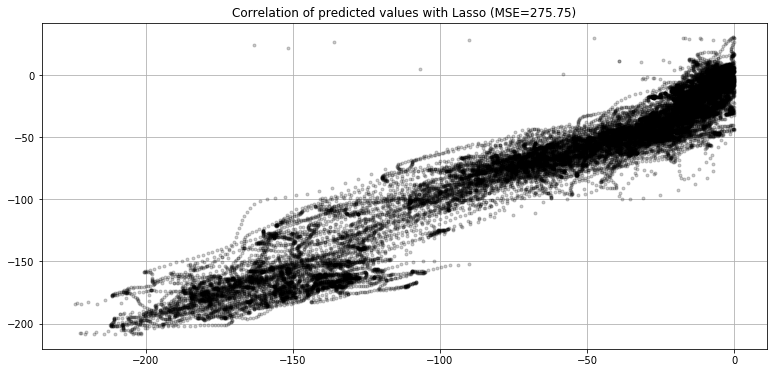

In [8]:
lassoreg = pipeline.Pipeline([
    ('scaler', preprocessing.StandardScaler()),
    ('lasso', linear_model.Lasso())
])
lassoreg.fit(df_train[features], df_train[targets])
mse_lassoreg = metrics.mean_squared_error(lassoreg.predict(df_test[features]), df_test[targets])
print(f"MSE(Lasso regression): {mse_lassoreg:.2f}")

ind = np.arange(len(features))
plt.bar(ind, np.abs(lassoreg.named_steps["lasso"].coef_))
plt.xticks(ind, features, rotation=90)
plt.title("Feature importance with Lasso");
plt.xlabel("Features")
plt.ylabel("Importance (coefficient)")

plt.figure()
plt.plot(df_test[targets], lassoreg.predict(df_test[features]), 'k.', alpha=.2)
plt.grid()
plt.title(f"Correlation of predicted values with Lasso (MSE={mse_lassoreg:.2f})");

## Gradient Boosting

In [9]:
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(df_train[features])
y_train = np.ravel(df_train[targets])
X_test = scaler.transform(df_test[features])
y_test = np.ravel(df_test[targets])

gboost = ensemble.GradientBoostingRegressor(
    n_estimators=200
)
gboost.fit(X_train, y_train)
mse_gboost = metrics.mean_squared_error(gboost.predict(X_test), y_test)
print(f"MSE(Gradient Boosting regression): {mse_gboost:.2f}")

MSE(Gradient Boosting regression): 193.64


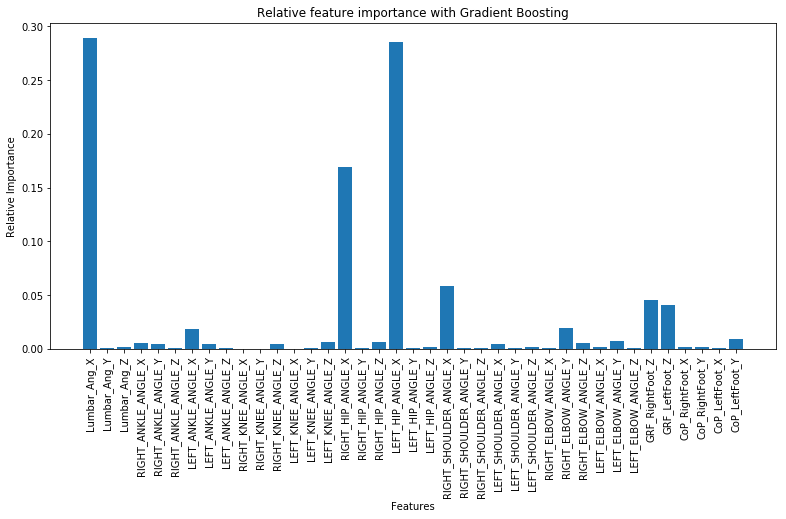

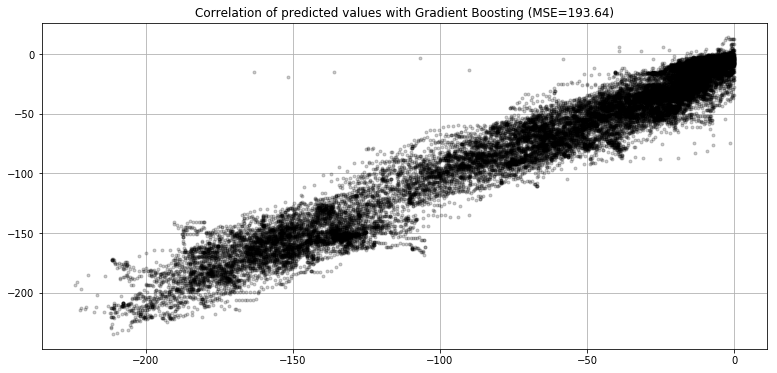

In [10]:
ind = np.arange(len(features))
plt.bar(ind, np.abs(gboost.feature_importances_))
plt.xticks(ind, features, rotation=90)
plt.title("Relative feature importance with Gradient Boosting");
plt.xlabel("Features")
plt.ylabel("Relative Importance")

plt.figure()
plt.plot(y_test, gboost.predict(X_test), 'k.', alpha=.2)
plt.grid()
plt.title(f"Correlation of predicted values with Gradient Boosting (MSE={mse_gboost:.2f})");

## Let's try XGBoost

In [11]:
!pip install --upgrade xgboost

    100% |████████████████████████████████| 142.8MB 390kB/s  eta 0:00:01   26% |████████▌                       | 38.0MB 98.3MB/s eta 0:00:02    29% |█████████▋                      | 42.8MB 96.1MB/s eta 0:00:02    85% |███████████████████████████▍    | 122.2MB 96.9MB/s eta 0:00:01
Requirement not upgraded as not directly required: numpy in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (from xgboost) (1.14.3)
Requirement not upgraded as not directly required: scipy in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (from xgboost) (1.1.0)
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [12]:
import xgboost as xgb

In [13]:
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(df_train[features])
y_train = np.ravel(df_train[targets])
X_test = scaler.transform(df_test[features])
y_test = np.ravel(df_test[targets])

xg_reg = xgb.XGBRegressor(objective="reg:squarederror", n_jobs=-1, n_estimators=200)
xg_reg.fit(X_train, y_train)
mse_xg_reg = metrics.mean_squared_error(xg_reg.predict(X_test), y_test)
print(f"MSE(XGBoost): {mse_xg_reg:.2f}")

MSE(XGBoost): 191.43


## TODO: 
 - Hyperparameter optimization for XGBoost (using SageMaker)
 - EM vs. PV dataset (train/test)
 - Leave out CoP column (NaN)
 - Prune the number of the features
 